# “All Press is Good Press?” : Analysis on the Relation Between Subreddit Reviews and Steam Player Counts

#### Team Members: James Clark (JAC692), Alexander Hertadi (AFH78), Katherine O’Conner (KSO25)

### Introduction and Problem Statement:

There is a famous saying “all press is good press”. Is this actually true? The aim of our project is to analyze the association between the sentiment and count of subreddit reviews of a few specific video games and their Steam player counts. We will attempt to measure video game sales via proxy through Steam player counts. There are two overarching goals:

- We want to explore how the play-style design of the game (single-release, single release and DLC content, single-release and updates) correlates to reddit traffic and steam player counts of the games over time. 
- We want to explore how negative vs. positive subreddit reviews correlate with Steam player count

With these goals in mind, we chose three games that each represented the play-style designs described above. We also opted for games released in 2016 as the Reddit torrent data is much smaller and more feasible to work with from that time frame. Also, since these games were released so long ago, we are better able to capture play trends and internet traffic patterns of the games over their most relevant timelines. We chose Dark Souls III, No Man’s Sky, and Stardew Valley. From our own background knowledge, No Man’s Sky is infamous for its negative review upon release, yet was still wildly popular.

### Hypothesis:

We expect to find that single release video games will have an initial surge in sales/player count and taper off with time, whereas video games that get patches or additional downloadable content will experience more stable sales/player count. We expect this same trend for the count of subreddit reviews. We expect no strong relationship between time of release and sentiment of reviews. 

Generally, we expect the number of Reddit reviews to be the most important predictor of Steam player counts. However, we predict that more positive sentiment reviews will be associated with more stable Steam player counts, whereas more negative sentiment reviews will be associated with sporadic steam player counts and an initial spike upon release. 



### Import Statements

In [74]:
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

In [17]:
# nltk.download('all')

### Load Output Data (Steam Player Counts)

In [153]:
darksouls3_y = pd.read_csv("Daily Dark Souls Player Count.csv").fillna(0)
no_mans_sky_y = pd.read_csv("Daily No Mans Sky Player Count.csv").fillna(0)
stardewvalley_y = pd.read_csv("Daily Stardew Player Count.csv").fillna(0)

In [192]:
darksouls3_y["DateTime"] = pd.to_datetime(pd.to_datetime(darksouls3_y["DateTime"]).dt.date)
no_mans_sky_y["DateTime"] = pd.to_datetime(pd.to_datetime(no_mans_sky_y["DateTime"]).dt.date)
stardewvalley_y["DateTime"] = pd.to_datetime(pd.to_datetime(stardewvalley_y["DateTime"]).dt.date)

C:\Users\kathe\AppData\Local\Temp\ipykernel_26828\212115054.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stardew_updates["Date"] = pd.to_datetime(stardew_updates["Date"])


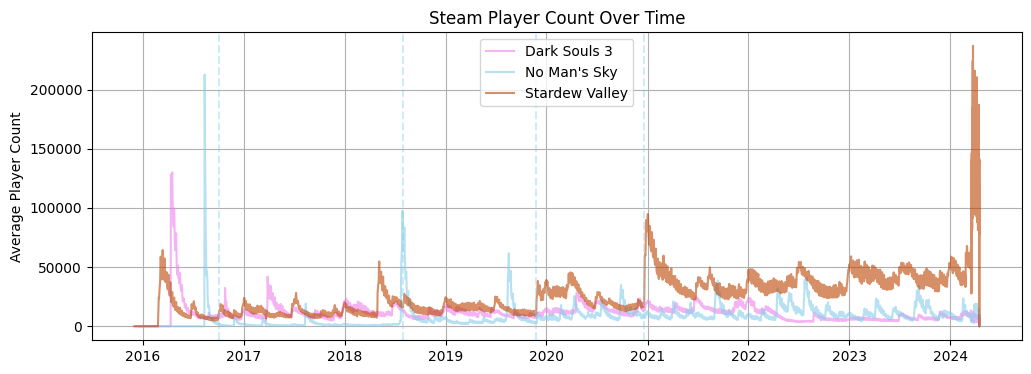

In [193]:
stardew_updates = pd.read_csv("Stardew Updates.csv")
stardew_updates["Date"] = pd.to_datetime(stardew_updates["Date"])

plt.figure(figsize=(12, 4))
games = [darksouls3_y, no_mans_sky_y, stardewvalley_y]
colors = ["violet", "skyblue", "#bd4404"]
for i in range(3):
    game = games[i]
    plt.plot(game["DateTime"], game["Players"], color = colors[i], alpha=0.6)

for i in range(len(stardew_updates)):
    plt.axvline(x = stardew_updates["Date"][i], linestyle="--", color="skyblue", alpha=0.4)

plt.grid()
plt.title("Steam Player Count Over Time")
plt.ylabel("Average Player Count")
plt.legend(labels=["Dark Souls 3", "No Man's Sky", "Stardew Valley"])
plt.show()

### Load Input Data (Subreddit Posts)

In [162]:
data = pd.read_json('filtered_post_combined.jsonl', lines=True)

data["created_utc"] = pd.to_datetime(data["created_utc"], unit='s')
data = data.loc[data['selftext'] != '[removed]']
data = data.loc[data['selftext'] != '[deleted]']
data = data.loc[data['selftext'] != '']
data = data.reset_index()

In [163]:
data

,index,is_self,secure_media,quarantine,thumbnail,from_kind,retrieved_on,author_flair_css_class,secure_media_embed,hide_score,...,spoiler,hidden,brand_safe,suggested_sort,author_cakeday,can_gild,thumbnail_width,thumbnail_height,view_count,is_video
0,0,True,None,False,self,NaN,1454965236,None,{},False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6,True,None,False,self,NaN,1454965831,sean,{},False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12,True,None,False,self,NaN,1454966492,None,{},False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13,True,None,False,self,NaN,1454966506,DaDa2BbT,{},False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14,True,None,False,self,NaN,1454966540,shipblue,{},False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239026,363221,True,None,False,self,NaN,1497200898,None,{},False,...,0.0,0.0,1.0,None,NaN,NaN,NaN,NaN,NaN,0.0
239027,363222,True,None,False,self,NaN,1497200905,None,{},False,...,0.0,0.0,1.0,None,NaN,NaN,NaN,NaN,NaN,0.0
239028,363223,True,None,False,self,NaN,1497200907,None,{},False,...,0.0,0.0,1.0,None,NaN,NaN,NaN,NaN,NaN,0.0
239029,363225,True,None,False,self,NaN,1497200922,None,{},False,...,0.0,0.0,1.0,None,NaN,NaN,NaN,NaN,NaN,0.0


In [58]:
def get_sentiment(data):
    sia = SentimentIntensityAnalyzer()
    negative = []
    neutral = []
    positive = []
    compound = []
    length = []
    subreddit = []
    for i in tqdm(range(len(data["selftext"]))):
        txt = data["selftext"][i]
        subreddit.append(data["subreddit"][i])
        result = sia.polarity_scores(txt)
        negative.append(result['neg'])
        positive.append(result['pos'])
        neutral.append(result['neu'])
        compound.append(result['compound'])
        length.append(len(txt))

    sentiment_df = pd.DataFrame({"created_utc": list(data["created_utc"]), "subreddit":subreddit,"Text": list(data["selftext"]), "negative": negative, "neutral":neutral, "positive": positive, "compound":compound, "length":length})
    return sentiment_df

# sentiment = get_sentiment(data)
# sentiment.to_csv("sentiment_csv")

sentiment = pd.read_csv("sentiment.csv")

100%|██████████| 239031/239031 [02:04<00:00, 1923.86it/s]


In [31]:
data.columns[data.isna().mean() < 0.9]

Index(['secure_media_embed', 'hide_score', 'url', 'gilded', 'permalink',
       'locked', 'media_embed', 'is_self', 'author_flair_css_class',
       'retrieved_on', 'quarantine', 'thumbnail', 'archived', 'edited',
       'author', 'over_18', 'link_flair_css_class', 'subreddit_id', 'selftext',
       'domain', 'author_flair_text', 'downs', 'title', 'num_comments',
       'subreddit', 'name', 'id', 'link_flair_text', 'ups', 'stickied',
       'score', 'created_utc', 'saved', 'preview', 'post_hint', 'contest_mode',
       'spoiler', 'hidden', 'brand_safe'],
      dtype='object')

In [164]:
stardewvalley_posts = data.loc[data['subreddit'] == 'StardewValley']
stardewvalley_sentiment = sentiment.loc[sentiment['subreddit'] == 'StardewValley']

no_mans_sky_posts = data.loc[data['subreddit'] == 'NoMansSkyTheGame']
no_mans_sky_sentiment = sentiment.loc[sentiment['subreddit'] == 'NoMansSkyTheGame']

darksouls3_posts = data.loc[data['subreddit'] == 'darksouls3']
darksouls3_sentiment = sentiment.loc[sentiment['subreddit'] == 'darksouls3']

In [216]:
darksouls3_sentiment

,created_utc,subreddit,Text,negative,neutral,positive,compound,length
0,2016-01-01 00:38:12,darksouls3,I'm not a traditional Souls player. The online...,0.045,0.806,0.149,0.9747,1282
2,2016-01-01 18:34:10,darksouls3,I must say that the Demon's Souls rolling from...,0.151,0.672,0.177,0.7168,727
3,2016-01-01 18:42:00,darksouls3,http://imgur.com/a/LUXbT\n\nFound it from this...,0.039,0.875,0.086,0.4155,277
5,2016-01-01 19:50:23,darksouls3,Maybe it me going crazy and like Caryll divini...,0.114,0.682,0.204,0.8377,455
6,2016-01-02 02:14:51,darksouls3,Personally I would prefer they do away with po...,0.064,0.936,0.000,-0.2617,182
...,...,...,...,...,...,...,...,...
239026,2017-05-31 23:27:20,darksouls3,[SotC](https://youtu.be/tfwFyL7l598)\n\nMy bes...,0.000,0.588,0.412,0.6369,66
239027,2017-05-31 23:29:39,darksouls3,can someone drop me a lightning urn and a mand...,0.106,0.707,0.187,0.1531,120
239028,2017-05-31 23:30:36,darksouls3,Looking for a calculator but failing to find o...,0.368,0.632,0.000,-0.9620,197
239029,2017-05-31 23:35:47,darksouls3,I struggled a bit through Dark Souls 1 with th...,0.043,0.772,0.185,0.9904,1289


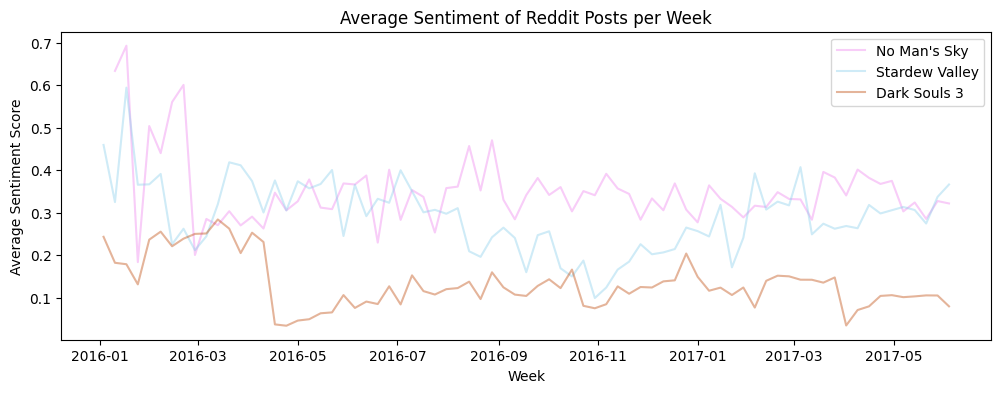

In [223]:
sentiments_list = [stardewvalley_sentiment, no_mans_sky_sentiment, darksouls3_sentiment]

plt.figure(figsize=(12,4))
for i in range(3):
    s = sentiments_list[i]
    plt.plot(s.groupby([pd.Grouper(key='created_utc', freq='W')])["compound"].mean(), color=colors[i], alpha=0.4)

plt.xlabel("Week")
plt.ylabel("Average Sentiment Score")
plt.title("Average Sentiment of Reddit Posts per Week")
plt.legend(labels=["No Man's Sky", "Stardew Valley", "Dark Souls 3"])
plt.show()

In [208]:
def clean_input_data(data, sentiment):
    data_group = data.groupby([pd.Grouper(key='created_utc', freq='D')])
    
    num_posts = data_group["id"].count()
    num_comments = data_group["num_comments"].sum()
    score = data_group["score"].mean()

    sentiment_group = sentiment.groupby([pd.Grouper(key='created_utc', freq='M')])
    sentiment_score = sentiment_group["compound"].mean()
    avg_length = sentiment_group["length"].mean()

    temp_df = pd.DataFrame({"num_posts": num_posts, "num_comments": num_comments, "average_score":score, "sentiment":sentiment_score, "average_length": avg_length})
    temp_df['created_utc'] = pd.to_datetime(temp_df.index)
    temp_df.index = range(len(temp_df))
    temp_df = temp_df.fillna(0)
    # temp_df.index = temp_df.index.to_period('M').to_timestamp()
    return temp_df
  
stardewvalley_x = clean_input_data(stardewvalley_posts, stardewvalley_sentiment)
no_mans_sky_x = clean_input_data(no_mans_sky_posts, no_mans_sky_sentiment)
darksouls3_x = clean_input_data(darksouls3_posts, darksouls3_sentiment)

stardewvalley_data = pd.merge(stardewvalley_x, stardewvalley_y, left_on='created_utc', right_on='DateTime', how="inner")
stardewvalley_data = stardewvalley_data.drop(columns=["DateTime", "Average Players"])
no_mans_sky_data = pd.merge(no_mans_sky_x, no_mans_sky_y, left_on='created_utc', right_on='DateTime', how="inner")
no_mans_sky_data = no_mans_sky_data.drop(columns=["DateTime", "Average Players"])
darksouls3_data = pd.merge(darksouls3_x, darksouls3_y, left_on='created_utc', right_on='DateTime', how="inner")
darksouls3_data = darksouls3_data.drop(columns=["DateTime", "Average Players"])

Text(0.5, 1.0, 'Stardewvalley Correlation Heatmap')

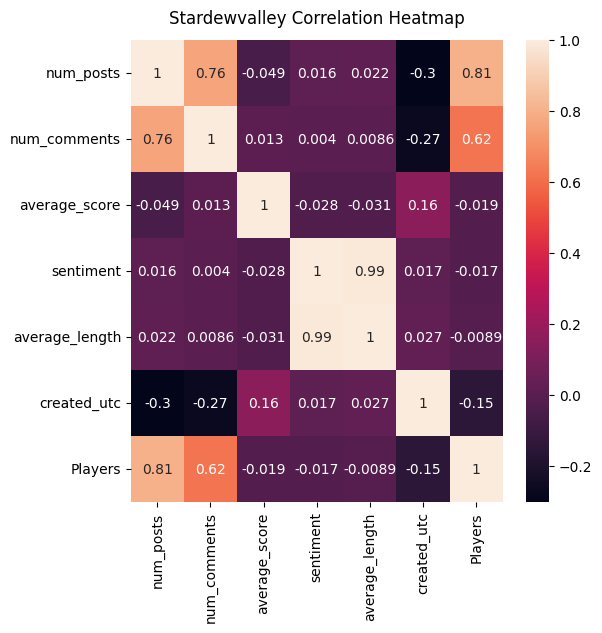

In [210]:
plt.figure(figsize=(6, 6))
stardewvalley_heatmap = sns.heatmap(stardewvalley_data.corr(), annot=True)
stardewvalley_heatmap.set_title('Stardewvalley Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

Text(0.5, 1.0, 'No Mans Sky Correlation Heatmap')

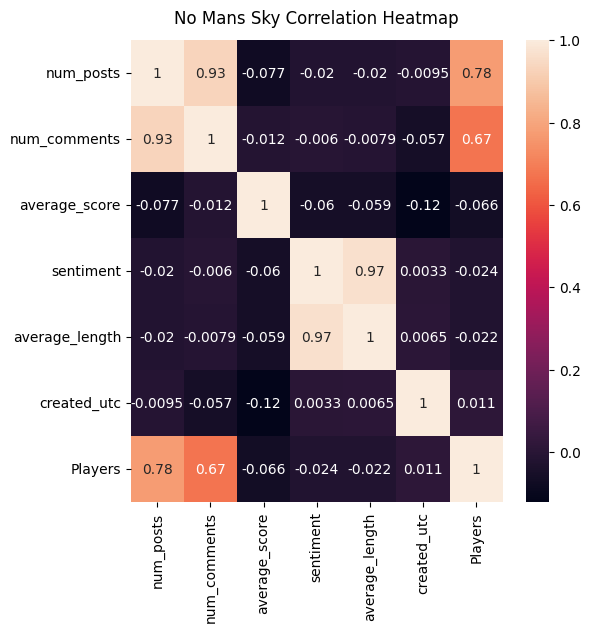

In [211]:
plt.figure(figsize=(6, 6))
no_mans_sky_heatmap = sns.heatmap(no_mans_sky_data.corr(), annot=True)
no_mans_sky_heatmap.set_title('No Mans Sky Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

Text(0.5, 1.0, 'Dark Souls 3 Correlation Heatmap')

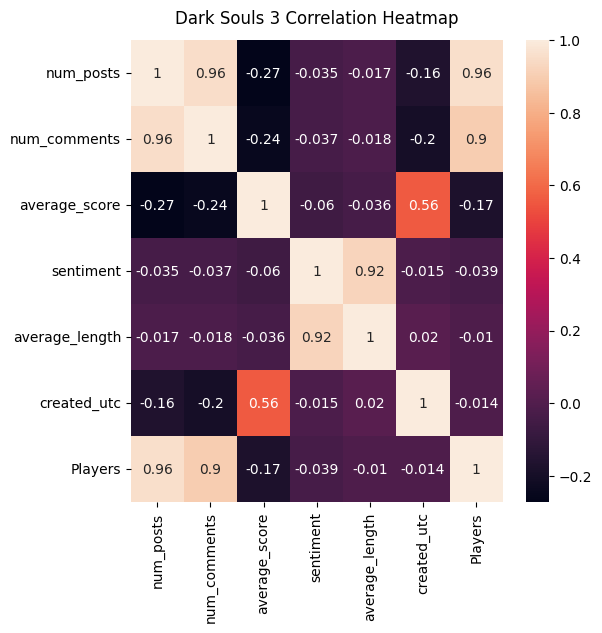

In [213]:
plt.figure(figsize=(6, 6))
darksouls3_heatmap = sns.heatmap(darksouls3_data.corr(), annot=True)
darksouls3_heatmap.set_title('Dark Souls 3 Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

In [245]:
stardewvalley_sentiment = stardewvalley_sentiment.reset_index()

In [246]:
worst_comment = stardewvalley_sentiment["Text"][stardewvalley_sentiment["compound"].argmin()]
print(worst_comment)

best_comment = stardewvalley_sentiment["Text"][stardewvalley_sentiment["compound"].argmax()]
# print(best_comment)

This is a continuation of the series on my take of each of the eligible bachelors/bachelorettes in Stardew Valley. As usual, I'm not a professional counselor... it's just my opinion, and they're open to discussion and debate. :)

Sebastian is a homicidal rage machine that wants to die. Do I have your attention?

Sebastian is a rebellious loner who is big into games, comics, and science fiction, works as a programmer, dresses like a goth rocker,  and lives in his parents' basement. Take a minute and absorb that little stereotype for a moment. Yeah, he's that guy. Ever wondered why some guys (and gals) end up like him? Let's take a look at Sebastian.

For those of you who read Maru's write-up, you know that she is a genius that is going to make a huge splash in this world. Imagine that you're her not-genius brother. In Maru's write-up, I mentioned that Maru was stable due to Robin's and Demetrius' good parenting, and that's true. That same good parenting, however, requires a LOT of atten

: 

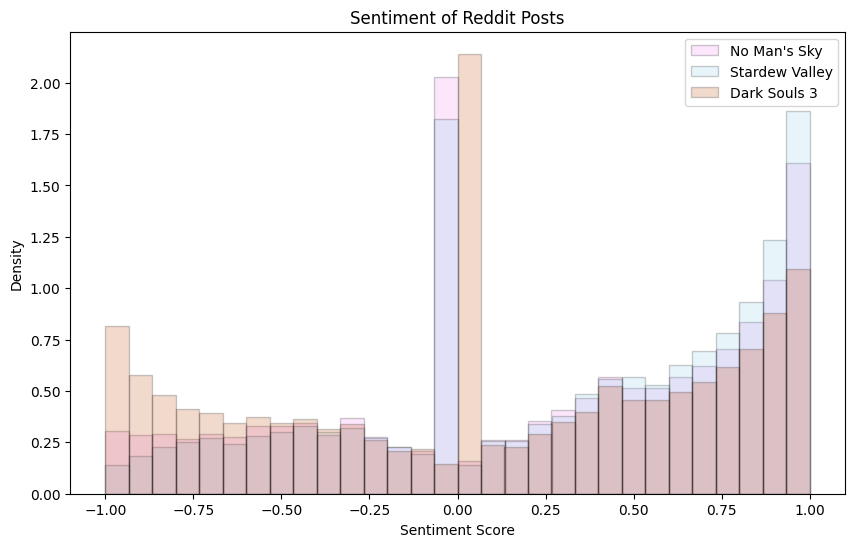

In [24]:

plt.figure(figsize=(10,6))

plt.hist(no_mans_sky_sentiment["compound"], bins=30, color = "violet", ec="black", alpha=0.2, density=True)
plt.hist(stardewvalley_sentiment["compound"], bins=30, color = "skyblue", ec="black", alpha=0.2, density=True)
plt.hist(darksouls3_sentiment["compound"], bins=30, color = "#bd4404", ec="black", alpha=0.2, density=True)

plt.xlabel("Sentiment Score")
plt.ylabel("Density")
plt.title("Sentiment of Reddit Posts")
plt.legend(labels=["No Man's Sky", "Stardew Valley", "Dark Souls 3"])
plt.show()


## Modeling

In [108]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier

import time

In [233]:
default_models = [LinearRegression(), Ridge(), KNeighborsClassifier(), KNeighborsRegressor(),
                  tree.DecisionTreeClassifier(), RandomForestClassifier(), tree.DecisionTreeRegressor(),
                  RandomForestRegressor()]

"""
Attempt various machine learning models and plot predicted values vs. true values of testing data set.
"""
def try_models(model_data, xcols, ycol, models=default_models):
    
    X = model_data[xcols]
    Y = model_data[ycol]

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # 20-80 train test split data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

    results = []
    mses = []
    
    fig, axs = plt.subplots(2, 4, figsize=(16,6))
    fig.suptitle(ycol)
    fig.tight_layout(h_pad=5, w_pad=2)
    fig.subplots_adjust(top=0.88)

    for i, model in enumerate(models):
        t1 = time.time()
        model.fit(X_train, Y_train)
        results.append(model)

        # store the predictions for the training and test set
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        # calculate error
                # calculate error
        error = pred_test - Y_test
        mse = round(sum(error**2) / len(error), 2)

        print(model)
        
        print("Training R^2 :", model.score(X_train, Y_train))
        print("Testing MSE:", mse)
        
        # print("Test Accuracy: ", accuracy_score(Y_test, pred_test))
        # print("Training Accuracy: ", accuracy_score(Y_train, pred_train))
        r = i//4
        c = i % 4
        t2 = time.time()
        print("Time:", t2-t1)
        # axs[r, c].hist(Y_test, alpha=0.6)
        # axs[r, c].hist(pred_test, alpha=0.6)
        axs[r,c].grid()
        axs[r,c].scatter(pred_test, Y_test, alpha=0.6)
        axs[r,c].scatter(pred_train, Y_train, alpha=0.6)
        axs[r,c].plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], linestyle="--", color="grey")
        axs[r, c].set_title(str(model) + "\n testing mse: " + str(mse))
        mses.append(mse)
        print()
    plt.savefig('try_models.png')
    plt.show()
    return results, mses

In [225]:
stardewvalley_data

,num_posts,num_comments,average_score,sentiment,average_length,created_utc,Players
0,1,34,32.000000,0.00000,0.000000,2016-01-04,1.0
1,1,5,18.000000,0.00000,0.000000,2016-01-05,2.0
2,0,0,0.000000,0.00000,0.000000,2016-01-06,1.0
3,1,20,27.000000,0.00000,0.000000,2016-01-07,3.0
4,0,0,0.000000,0.00000,0.000000,2016-01-08,2.0
...,...,...,...,...,...,...,...
509,12,133,30.250000,0.00000,0.000000,2017-05-27,10114.0
510,10,73,7.400000,0.00000,0.000000,2017-05-28,10590.0
511,22,195,8.318182,0.00000,0.000000,2017-05-29,9828.0
512,17,178,8.647059,0.00000,0.000000,2017-05-30,9030.0


In [227]:
stardewvalley_data_cat = stardewvalley_data
stardewvalley_data_cat["subreddit"] = 0
no_mans_sky_data_cat = no_mans_sky_data
no_mans_sky_data_cat["subreddit"] = 1
darksouls3_data_cat = darksouls3_data
darksouls3_data_cat["subreddit"] = 2
all_data = pd.concat([stardewvalley_data_cat, no_mans_sky_data_cat, darksouls3_data_cat ])
all_data["created_utc"] = all_data["created_utc"].astype('int64')

Text(0.5, 1.0, 'All Games Correlation Heatmap')

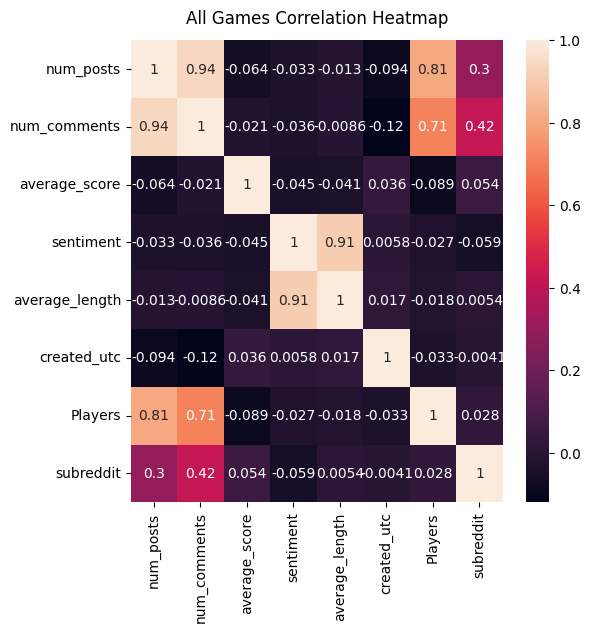

In [228]:
plt.figure(figsize=(6,6))
all_data_heatmap = sns.heatmap(all_data.corr(), annot=True)
all_data_heatmap.set_title('All Games Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

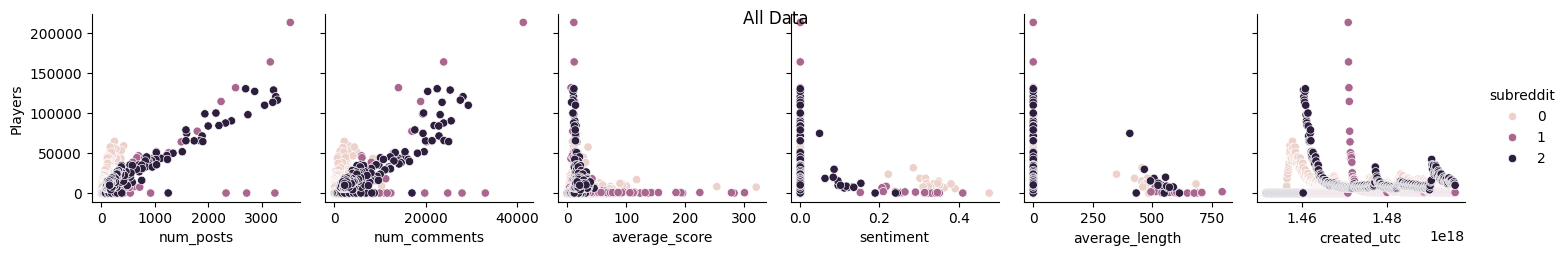

In [231]:
# sns.pairplot(data = stardewvalley_data, x_vars = xcols, y_vars = ycol, color="skyblue")
# plt.suptitle("Stardewvalley Data")
# plt.show()

sns.pairplot(data = all_data, x_vars = xcols, y_vars = ycol, hue="subreddit")
plt.suptitle("All Data")
plt.show()

LinearRegression()
Training R^2 : 0.6262318310880357
Testing MSE: 54904744.93
Time: 0.0019991397857666016

Ridge()
Training R^2 : 0.6262155742330093
Testing MSE: 55034609.78
Time: 0.0019991397857666016

KNeighborsRegressor()
Training R^2 : 0.8069535889799087
Testing MSE: 44500806.51
Time: 0.013001203536987305

DecisionTreeRegressor()
Training R^2 : 0.9999999999871797
Testing MSE: 110976567.01
Time: 0.009513616561889648

RandomForestRegressor()
Training R^2 : 0.9592102552892072
Testing MSE: 52764894.5
Time: 0.7038459777832031



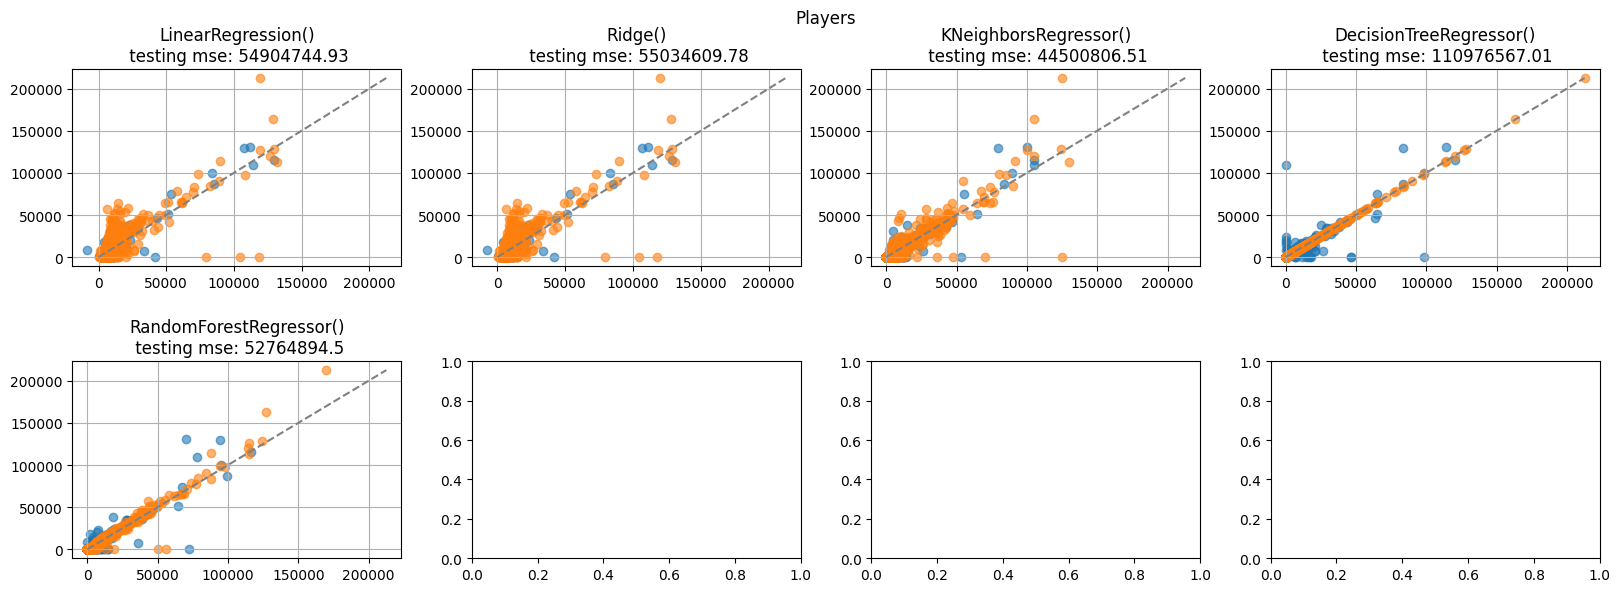

In [235]:
xcols = ['num_posts', 'num_comments', 'average_score', 'sentiment',
       'average_length', 'created_utc']
ycol = 'Players'

default_models = [LinearRegression(), Ridge(), KNeighborsRegressor(), tree.DecisionTreeRegressor(),
                  RandomForestRegressor()]
models, mses = try_models(all_data, xcols, ycol, default_models)

LinearRegression()
Training R^2 : 0.6841301160151001
Testing MSE: 47482566.07
Time: 0.002010822296142578

Ridge()
Training R^2 : 0.6840876175815844
Testing MSE: 46967613.61
Time: 0.0019996166229248047

KNeighborsRegressor()
Training R^2 : 0.8889740929243766
Testing MSE: 20283978.42
Time: 0.004885196685791016

DecisionTreeRegressor()
Training R^2 : 1.0
Testing MSE: 14891086.24
Time: 0.00468754768371582

RandomForestRegressor()
Training R^2 : 0.987360217530104
Testing MSE: 10300215.53
Time: 0.24471712112426758



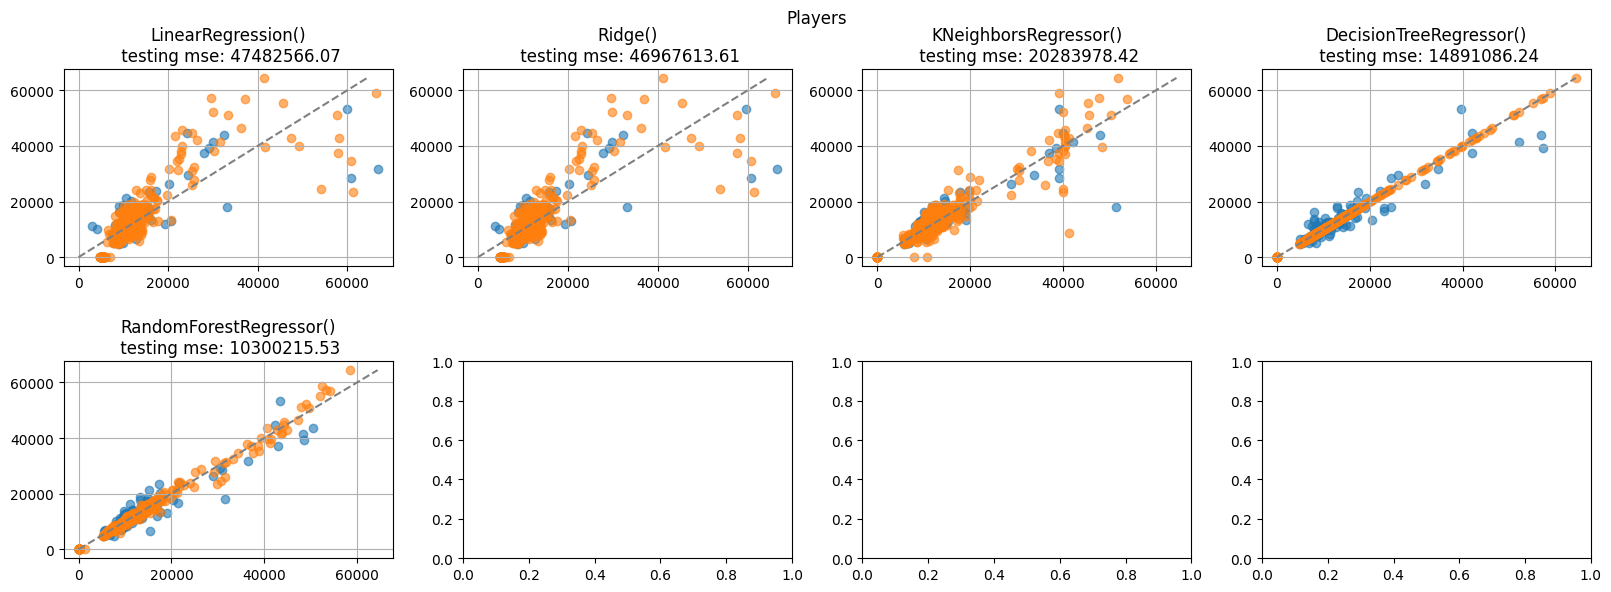

In [242]:
stardewvalley_mod_data = stardewvalley_data
stardewvalley_mod_data["created_utc"] = stardewvalley_mod_data["created_utc"].astype('int64')
stardewvalley_models, stardewvalley_mses = try_models(stardewvalley_mod_data, xcols, ycol, default_models)

LinearRegression()
Training R^2 : 0.6187093819024996
Testing MSE: 3182623.88
Time: 0.002005338668823242

Ridge()
Training R^2 : 0.6186434615300122
Testing MSE: 3127630.87
Time: 0.0010013580322265625

KNeighborsRegressor()
Training R^2 : 0.5955669805664559
Testing MSE: 1314092.84
Time: 0.0060079097747802734

DecisionTreeRegressor()
Training R^2 : 1.0
Testing MSE: 142608.29
Time: 0.0035169124603271484

RandomForestRegressor()
Training R^2 : 0.9362294077255103
Testing MSE: 174159.73
Time: 0.22955846786499023



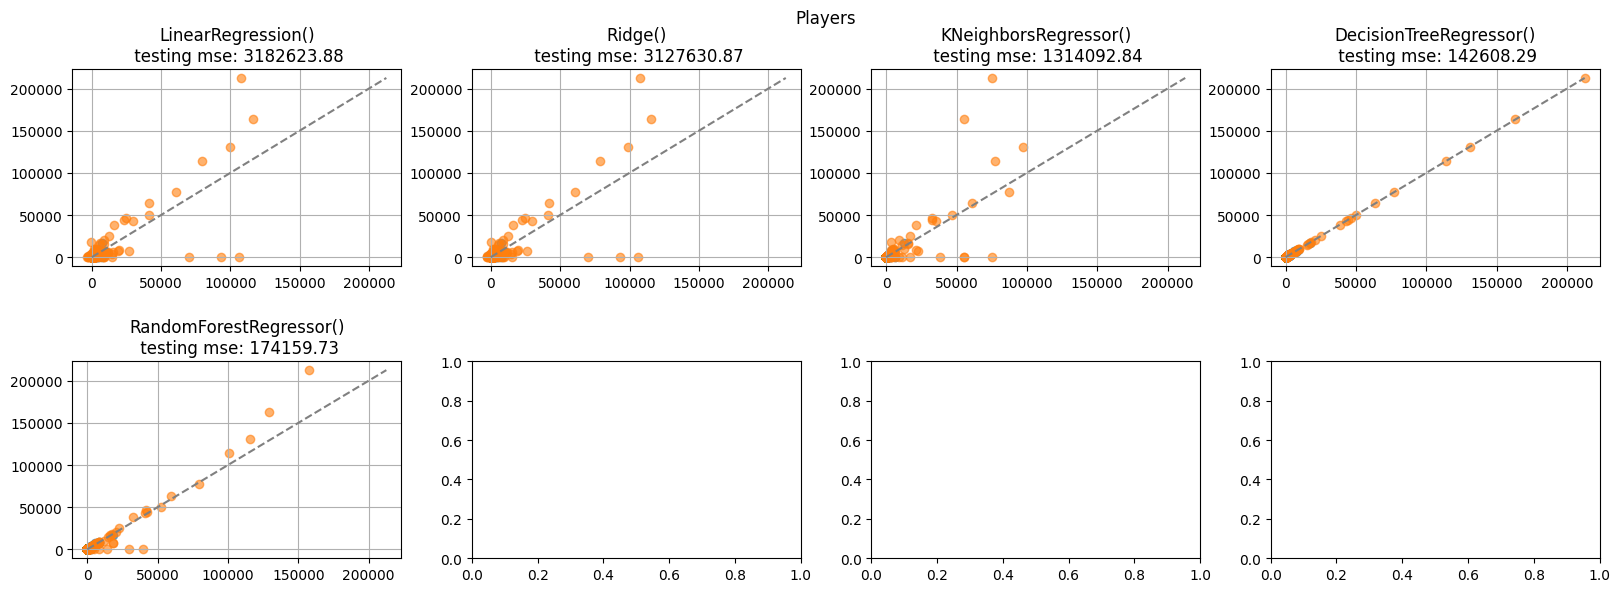

In [241]:
no_mans_sky_mod_data = no_mans_sky_data
no_mans_sky_mod_data["created_utc"] = no_mans_sky_mod_data["created_utc"].astype('int64')
no_mans_sky_models, no_mans_sky_mses = try_models(no_mans_sky_mod_data, xcols, ycol, default_models)

In [237]:
forrest_model = models[-1]

num_posts         0.643161
created_utc       0.175664
num_comments      0.114621
average_score     0.065543
sentiment         0.000786
average_length    0.000224
dtype: float64

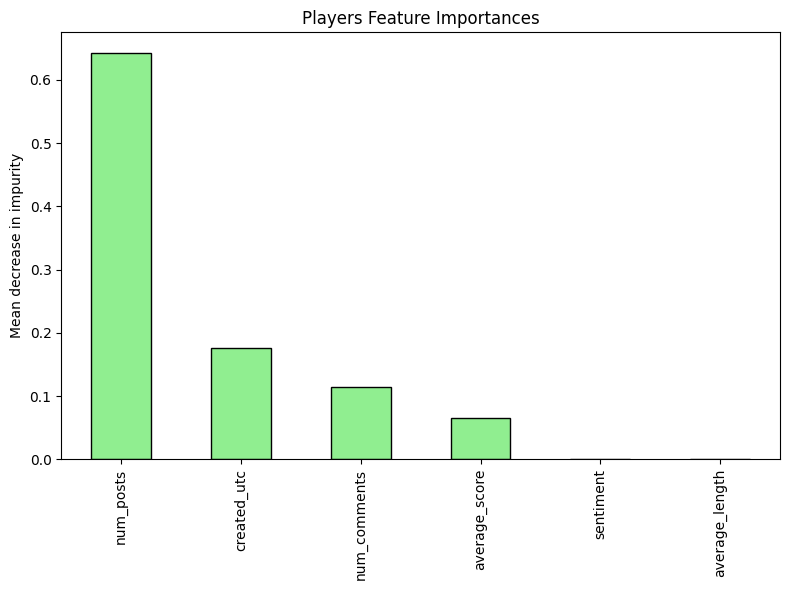

In [240]:
def MIDI_graph(model, feature_names, yname, n=None, plot=False):
    if n ==  None:
        n = len(feature_names)

    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=feature_names)
    forest_importances = forest_importances.sort_values(ascending=False)[0:n]

    fig, ax = plt.subplots(figsize=(8, 6))
    forest_importances.plot.bar(ax=ax, color = "lightgreen", ec="black")
    ax.set_title("{} Feature Importances".format(yname))
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    return forest_importances

MIDI_graph(forrest_model, xcols, ycol)